In [1]:
# Install library
# !pip install https://github.com/LevPerla/Time_Series_Prediction_RNN/archive/master.zip

In [2]:
#################################           Load libs                      #############################################
import os
import numpy as np
import pandas as pd
from tensorflow.keras import callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
%matplotlib inline

from ts_rnn.ts_rnn_model import TS_RNN
from ts_rnn.utils import metrics_eval, train_test_pred_plot

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Univariate prediction

In [3]:
TEST_LEN = 12

# Import targets
target = pd.read_csv("https://raw.githubusercontent.com/LevPerla/Time_Series_Prediction_RNN/master/data/series_g.csv", sep=";").series_g.values
target_train, target_test = train_test_split(target, test_size=TEST_LEN, shuffle=False)

In [4]:
# Deseason
result = seasonal_decompose(target_train, model='multiplicative', freq=12)
target_train_deseason = (result.observed / result.seasonal)
train_seasonal = result.seasonal
test_season = train_seasonal[train_seasonal.tolist().index(train_seasonal[-1]) + 1:
                            train_seasonal.tolist().index(train_seasonal[-1]) + TEST_LEN + 1]
target_test_deseason = target_test / test_season

/opt/anaconda3/envs/TS_RNN/lib/python3.7/site-packages/ipykernel-6.0.0a4-py3.7.egg/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


In [5]:
# Scale target
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_train_std = target_scaler.fit_transform(target_train_deseason.reshape(-1, 1))
target_test_std = target_scaler.transform(target_test_deseason.reshape(-1, 1))
target_std = np.concatenate([target_train_std, target_test_std])

In [6]:
# Create folder for reports
if "reports" not in os.listdir('..'):
    os.makedirs("../reports")
new_folder_num = str(len(os.listdir('../reports')) + 1)
new_folder = os.path.join("../reports", new_folder_num)
os.mkdir(new_folder)

rnn_arch = {"layers": [
                        ["LSTM", {"units": 64,
                                  "return_sequences": False,
                                  "kernel_initializer": "glorot_uniform",
                                  "activation": "linear"}],
                        ["Dropout", {"rate": 0.2}],
                        ["Dense", {"activation": "linear"}]
                    ]}

model = TS_RNN(rnn_arch=rnn_arch,
               n_step_in=12,
               horizon=TEST_LEN,
               test_len=TEST_LEN,
               strategy="MiMo", #"Direct", "Recursive", "MiMo"
               save_dir=new_folder,
               loss="mae",
               optimizer="adam"
               )
model.summary()

Model: "MiMo_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 12)                780       
Total params: 17,676
Trainable params: 17,676
Non-trainable params: 0
_________________________________________________________________


/opt/anaconda3/envs/TS_RNN/lib/python3.7/site-packages/scikit_learn-0.24.1-py3.7-macosx-10.9-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Epoch 1/100
4/4 [==============================] - 2s 116ms/step - loss: 0.3365 - val_loss: 0.9021
Epoch 2/100
4/4 [==============================] - 0s 19ms/step - loss: 0.3045 - val_loss: 0.8227
Epoch 3/100
4/4 [==============================] - 0s 18ms/step - loss: 0.2634 - val_loss: 0.7063
Epoch 4/100
4/4 [==============================] - 0s 16ms/step - loss: 0.2067 - val_loss: 0.5051
Epoch 5/100
4/4 [==============================] - 0s 16ms/step - loss: 0.1506 - val_loss: 0.3690
Epoch 6/100
4/4 [==============================] - 0s 17ms/step - loss: 0.1378 - val_loss: 0.2470
Epoch 7/100
4/4 [==============================] - 0s 16ms/step - loss: 0.1085 - val_loss: 0.1483
Epoch 8/100
4/4 [==============================] - 0s 1

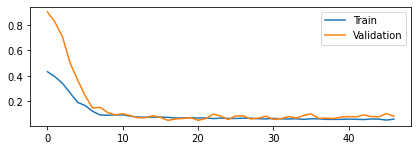

In [7]:
my_callbacks = [callbacks.EarlyStopping(patience=30, monitor='val_loss')]

model.fit(target=target_std,
          epochs=100,
          batch_size=12,
          callbacks=my_callbacks,
          verbose=1);

Mean Absolute Error: 24.058
Mean Squared Error: 812.683
Scaled Mean absolute percentage error: 4.932
Root Mean Squared Error: 28.508
Mean absolute percentage error: 4.824


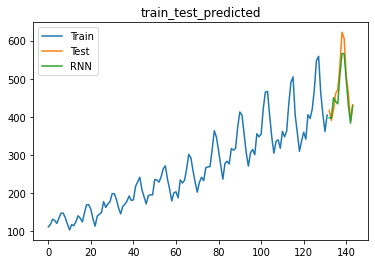

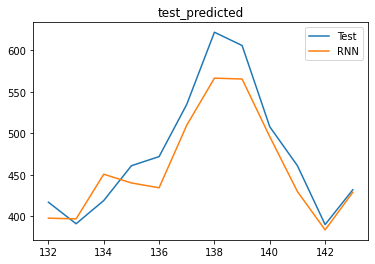

In [8]:
predicted_std = model.predict(target=target_train_std[-model.n_step_in:], prediction_len=TEST_LEN)
# inverse transform
predicted_deseason = target_scaler.inverse_transform(predicted_std.reshape(-1, 1)).flatten()
# Add season
predicted_rnn = predicted_deseason * test_season

metrics_eval(target_test[:len(predicted_rnn)], predicted_rnn, print_result=True, save_dir=new_folder)

predicted = {"RNN": {"predictions": predicted_rnn}}

train_test_pred_plot(train=target_train, test=target_test, predicted=predicted,
                     save_dir=new_folder, show=True);

## Mulrivariate prediction (Target + Factors)

In [9]:
# Import targets
target = pd.read_csv("https://raw.githubusercontent.com/LevPerla/Time_Series_Prediction_RNN/master/data/series_g.csv", sep=";").series_g.values

# Generate factors
f1 = np.arange(1, len(target) + 1).reshape(-1, 1)
f2 = (np.arange(1, len(target) + 1) ** 2).reshape(-1, 1)
factors = np.hstack((f1, f2))

factors_train, factors_test, target_train, target_test = train_test_split(factors,
                                                                          target,
                                                                          test_size=TEST_LEN,
                                                                          random_state=42,
                                                                          shuffle=False)

In [10]:
# Deseason
result = seasonal_decompose(target_train, model='multiplicative', freq=12)
target_train_deseason = (result.observed / result.seasonal)
train_seasonal = result.seasonal
test_season = train_seasonal[train_seasonal.tolist().index(train_seasonal[-1]) + 1:
                            train_seasonal.tolist().index(train_seasonal[-1]) + TEST_LEN + 1]
target_test_deseason = target_test / test_season

# Scale target
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_train_std = target_scaler.fit_transform(target_train_deseason.reshape(-1, 1))
target_test_std = target_scaler.transform(target_test_deseason.reshape(-1, 1))
target_std = np.concatenate([target_train_std, target_test_std])

#scale factors
factors_scaler = MinMaxScaler(feature_range=(0, 1))
factors_train_std = factors_scaler.fit_transform(factors_train)
factors_test_std = factors_scaler.transform(factors_test)
factors_std = np.concatenate([factors_train_std, factors_test_std])

/opt/anaconda3/envs/TS_RNN/lib/python3.7/site-packages/ipykernel-6.0.0a4-py3.7.egg/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


In [11]:
rnn_arch = {"layers": [
        ["LSTM", {"units": 128,
                  "return_sequences": False,
                  "kernel_initializer": "glorot_uniform",
                  "activation": "linear"}],
        ["Dropout", {"rate": 0.2}],
        ["Dense", {"activation": "linear"}]
    ]
}

In [12]:
model = TS_RNN(rnn_arch=rnn_arch,
               n_step_in=12,
               horizon=TEST_LEN,
               test_len=TEST_LEN,
               strategy="MiMo",
               save_dir=new_folder,
               loss="mae",
               optimizer="adam",
               n_features=factors_train_std.shape[1]  # also you need to define this if use factors
               )
model.summary()

Model: "MiMo_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               67584     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1548      
Total params: 69,132
Trainable params: 69,132
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Create folder for reports
try:
    os.chdir("../reports")
except:
    os.makedirs("../reports")
    os.chdir("../reports")
new_folder_num = str(len(os.listdir()) + 1)
new_folder = "%s/%s" % ("../reports", new_folder_num)
os.mkdir(new_folder)

Epoch 1/100
4/4 [==============================] - 3s 145ms/step - loss: 0.3177 - val_loss: 0.7287
Epoch 2/100
4/4 [==============================] - 0s 24ms/step - loss: 0.2218 - val_loss: 0.3322
Epoch 3/100
4/4 [==============================] - 0s 30ms/step - loss: 0.1146 - val_loss: 0.3004
Epoch 4/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0807 - val_loss: 0.0702
Epoch 5/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0701 - val_loss: 0.1462
Epoch 6/100
4/4 [==============================] - 0s 33ms/step - loss: 0.0674 - val_loss: 0.1147
Epoch 7

/opt/anaconda3/envs/TS_RNN/lib/python3.7/site-packages/scikit_learn-0.24.1-py3.7-macosx-10.9-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


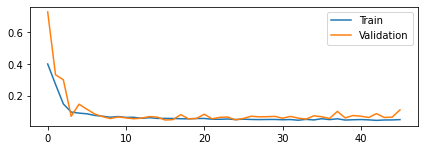

In [14]:
my_callbacks = [callbacks.EarlyStopping(patience=30, monitor='val_loss')]

model.fit(factors=factors_std,  # also you need to define this if use factors
          target=target_std,
          epochs=100,
          batch_size=12,
          callbacks=my_callbacks,
          verbose=1)

/opt/anaconda3/envs/TS_RNN/lib/python3.7/site-packages/scikit_learn-0.24.1-py3.7-macosx-10.9-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Mean Absolute Error: 38.578
Mean Squared Error: 2067.835
Scaled Mean absolute percentage error: 8.075
Root Mean Squared Error: 45.473
Mean absolute percentage error: 7.684


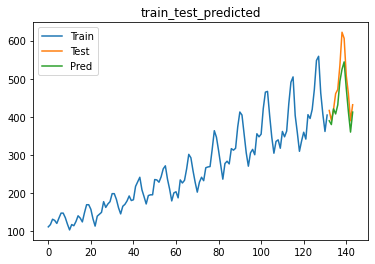

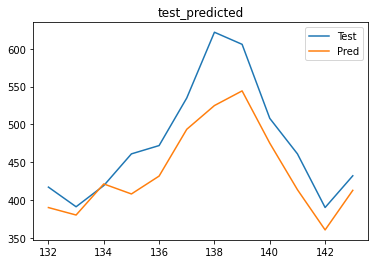

In [15]:
predicted_std = model.predict(
    factors=factors_train_std[-model.n_step_in:],  # also you need to define this if use factors
    target=target_train_std[-model.n_step_in:],
    prediction_len=TEST_LEN
)

# inverse transform
predicted_deseason = target_scaler.inverse_transform(predicted_std.reshape(-1, 1)).flatten()
# Add season
predicted = predicted_deseason * test_season

metrics_eval(target_test[:len(predicted)], predicted, print_result=True, save_dir=new_folder)
train_test_pred_plot(train=target_train, test=target_test, predicted=predicted, save_dir=new_folder);